In [ ]:
! pip install mysql-connector-python
! pip install matplotlibpip install matplotlib
! pip install mysql
! pip install gspread-dataframe
! pip install -U numpy
! pip install yfinance

In [20]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
import json
import csv
import datetime
import numpy as np
import mysql.connector
from functools import lru_cache

import gspread
from google.oauth2.service_account import Credentials
import gspread_dataframe as gd
from functools import lru_cache
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [37]:
import datetime
import pandas as pd
import yfinance as yf

def cal_change(symbols,finish_date,min_percentage_change, max_percentage_change):
    import datetime
    import pandas as pd
    import yfinance as yf

    end_date = datetime.date.fromisoformat(finish_date)
    start_date = datetime.date.fromisoformat('2022-01-01')

    # Initialize an empty DataFrame to store all data
    all_data = pd.DataFrame()



    for symbol in symbols:

        symbol_with_extension = f"{symbol}.BK"

        try:
            # Download data for the symbol
            data = yf.download(symbol_with_extension, start=start_date, end=end_date)

            # Check if data is not empty
            if not data.empty:
                # Add a 'Symbol' column and set it to the current symbol
                data['Symbol'] = symbol

                # Concatenate data to the all_data DataFrame
                all_data = pd.concat([all_data, data])
        except Exception as e:
            print(f"Error downloading data for {symbol_with_extension}: {e}")

    # Sort data by index (Date)
    all_data.sort_index(inplace=True)

    # Calculate %Change
    all_data['%Change'] = all_data.groupby('Symbol')['Close'].pct_change() * 100


    # Filter data based on the %Change condition
    if min_percentage_change is not None and max_percentage_change is not None:
        filtered_df = all_data[(all_data['%Change'] >= min_percentage_change) & (all_data['%Change'] <= max_percentage_change)]
    else:
        filtered_df = all_data

    # Sort and reset index
    filtered_df = filtered_df.sort_values(by=['Symbol', 'Date'])
    filtered_df.reset_index(inplace=True)

    row_count = len(filtered_df)

    return row_count
row_count = cal_change(symbols,finish_date,min_percentage_change, max_percentage_change)
row_count

[*********************100%%**********************]  1 of 1 completed


227

In [22]:
import yfinance as yf
import datetime

def cal_date(symbols,finish_date,min_percentage_change, max_percentage_change):

    # กำหนด Symbol ของหุ้น
    symbols = [f"{symbol}.BK" for symbol in symbols]


    # กำหนดวันที่เริ่มต้นและวันที่สิ้นสุด (5 วันย้อนหลัง)
    end_date = datetime.date.fromisoformat(finish_date)
    start_date = end_date - datetime.timedelta(days=50)

    # ดึงข้อมูลการซื้อขาย
    data = yf.download(symbols, start=start_date, end=end_date)

    # ตรวจสอบว่ามีข้อมูลการซื้อขายในแต่ละวันหรือไม่
    trading_dates = data.index.date

    # สร้าง DataFrame ด้วยข้อมูลการซื้อขายและคอลัมน์ Symbol
    trading_dates = pd.DataFrame({'Symbol': [symbols[0]] * len(trading_dates), 'Date': trading_dates})
    trading_dates = trading_dates.sort_values(by='Date', ascending=False)

    # Calculate 'DayTrade_before' as the previous trading day
    trading_dates['DayTrade_before'] = trading_dates['Date'].shift(-1)
    trading_dates['DayTrade_before'].fillna(method='ffill', inplace=True)

    trading_dates = trading_dates.iloc[:day+1]

    df = trading_dates.drop(trading_dates.index[-1])
    df['Symbol'] = df['Symbol'].str.replace('.BK', '')
    return df


In [23]:
import mysql.connector
import pandas as pd
from decimal import Decimal

def find_atoside():
    df = cal_date(symbols,finish_date,min_percentage_change, max_percentage_change).copy()
# สร้างการเชื่อมต่อกับ MySQL Database
    mydb = mysql.connector.connect(
        host="xxx",
        user="xxx",
        password="xxx",
        database="xxx",
        port=xxx
    )

    # สร้าง cursor เพื่อใช้ในการ execute คำสั่ง SQL
    mycursor = mydb.cursor()

    # คำสั่ง SQL ที่ต้องการ execute
    query = """
    SELECT
        AA.DateTime as Date,
        AA.Symbol,
        AA.First_Last,
        COALESCE(BB.datebefore, AA.DateTime - INTERVAL 1 DAY) AS DayTrade_before,
        COALESCE(BB.end_Last, 'none') AS end_Last
    FROM
    (
        SELECT
            MIN(DATE(DtMinOfRec)) AS DateTime,
            Symbol,
            Last AS First_Last
        FROM stocksm_tickmatchs
        WHERE Type IN ('BUY', 'SELL')
            AND DATE(DtMinOfRec) = '{date}'
            AND Symbol = '{symbol}'
        GROUP BY DATE(DtMinOfRec), Symbol
    ) AS AA
    LEFT JOIN
    (
        SELECT
            MAX(DATE(DtMinOfRec)) AS datebefore,
            Symbol,
            Last AS end_Last
        FROM stocksm_tickmatchs
        WHERE Type IN ('BUY', 'SELL')
            AND DATE(DtMinOfRec) = '{date2}'
            AND Symbol = '{symbol}'
        GROUP BY Symbol
    ) AS BB
    ON AA.DateTime >= BB.datebefore;
    """

    # รายการสัญลักษณ์ที่คุณต้องการรัน
    symbols_list = df['Symbol'].tolist()
    date_list = df['Date'].tolist()
    date2_list = df['DayTrade_before'].tolist()

    # สร้าง DataFrame สำหรับผลลัพธ์
    df_list = []

    for symbol_to_query, date_to_query, date2_to_query in zip(symbols_list, date_list, date2_list):
        # สร้างคำสั่ง SQL ที่ใช้ f-string เพื่อใส่ค่าแทนที่แทน {symbol} และ {date}
        formatted_query = query.format(symbol=symbol_to_query, date=date_to_query, date2=date2_to_query)

        # execute คำสั่ง SQL
        mycursor.execute(formatted_query)

        # อ่านผลลัพธ์จากคำสั่ง SQL
        myresult = mycursor.fetchall()

        # รับชื่อคอลัมน์ของผลลัพธ์จากคำสั่ง SQL
        column_names = [desc[0] for desc in mycursor.description]

        # สร้าง DataFrame โดยใช้ผลลัพธ์ที่ได้จากการ query และตั้งชื่อคอลัมน์ตาม column_names
        df = pd.DataFrame(myresult, columns=column_names)

        df_list.append(df)

    # ปิด cursor และการเชื่อมต่อ MySQL
    mycursor.close()
    mydb.close()

    # รวม DataFrame ทั้งหมดใน df_list เป็น DataFrame เดียว
    final_df3 = pd.concat(df_list, ignore_index=True)

    # แปลงคอลัมน์ "end_Last" เป็น numeric ก่อน
    final_df3['end_Last'] = pd.to_numeric(final_df3['end_Last'], errors='coerce')

    # แปลงคอลัมน์ "end_Last" เป็น decimal.Decimal
    final_df3['end_Last'] = final_df3['end_Last'].apply(Decimal)
    final_df3['Date'] = pd.to_datetime(final_df3['Date'])
    final_df3['DayTrade_before'] = pd.to_datetime(final_df3['DayTrade_before'])

    # วนลูปผ่านแถวของ DataFrame เพื่อแก้ไขค่า 'end_Last' ในแถวที่ 'end_Last' เป็น NaN
    for index, row in final_df3.iterrows():
        if pd.isna(row['end_Last']):
            if pd.notna(row['Date']):
                new_date = row['Date'] - pd.DateOffset(days=2)  # Subtract 2 days from the DateTime
                formatted_date = new_date.strftime('%Y-%m-%d')  # Format the new_date as a string
                final_df3.at[index, 'DayTrade_before'] = formatted_date
    # Format the new_date as a string

    final_df3['side_ato'] = np.where(final_df3['First_Last'] > final_df3['end_Last'], 1, np.where(final_df3['First_Last'] < final_df3['end_Last'], -1, np.where(final_df3['First_Last'] == final_df3['end_Last'], 0, 1)))



    # เมื่อลูปเสร็จสิ้นแล้ว คอลัมน์ 'end_Last' จะไม่มีค่า NaN อีก
    return final_df3


In [24]:
def final_df4():
    final_df3 = find_atoside()
    #ดึงข้อมูลเพื่อจะคิด value
    import mysql.connector
    import pandas as pd
    from decimal import Decimal

    # สร้างการเชื่อมต่อกับ MySQL Database
    mydb = mysql.connector.connect(
        host="xxx",
        user="xxx",
        password="xxx",
        database="xxx",
        port=xxx
    )

    # สร้าง cursor เพื่อใช้ในการ execute คำสั่ง SQL
    mycursor = mydb.cursor()

    # คำสั่ง SQL ที่ต้องการ execute
    query = """
    SELECT
    Symbol,
    Last,
    Vol,
    Type,
    Date(DtMinOfRec)	as Date,
    DtMinOfRec	as DateTime

    FROM stocksm_tickmatchs
    WHERE DATE(DtMinOfRec) = '{date}' AND Symbol = '{symbol}';

    """

    # รายการสัญลักษณ์ที่คุณต้องการรัน
    symbols_list = final_df3['Symbol'].tolist()
    date_list = final_df3['Date'].tolist()


    # สร้าง DataFrame สำหรับผลลัพธ์
    df_list = []

    for symbol_to_query, date_to_query in zip(symbols_list, date_list):
        # สร้างคำสั่ง SQL ที่ใช้ f-string เพื่อใส่ค่าแทนที่แทน {symbol} และ {date}
        formatted_query = query.format(symbol=symbol_to_query, date=date_to_query)

        # execute คำสั่ง SQL
        mycursor.execute(formatted_query)

        # อ่านผลลัพธ์จากคำสั่ง SQL
        myresult = mycursor.fetchall()

        # รับชื่อคอลัมน์ของผลลัพธ์จากคำสั่ง SQL
        column_names = [desc[0] for desc in mycursor.description]

        # สร้าง DataFrame โดยใช้ผลลัพธ์ที่ได้จากการ query และตั้งชื่อคอลัมน์ตาม column_names
        df = pd.DataFrame(myresult, columns=column_names)

        df_list.append(df)

    # ปิด cursor และการเชื่อมต่อ MySQL
    mycursor.close()
    mydb.close()

    # รวม DataFrame ทั้งหมดใน df_list เป็น DataFrame เดียว
    final_df4 = pd.concat(df_list, ignore_index=True)

        # แปลงคอลัมน์ "Date" ใน final_df3 เป็น datetime64[ns]
    final_df3['Date'] = pd.to_datetime(final_df3['Date'])
    final_df4['Date'] = pd.to_datetime(final_df4['Date'])
    # ใช้ merge เพื่อ join final_df4 และ final_df3 โดยใช้ Date และ Symbol เป็นเงื่อนไข
    merged_df = final_df4.merge(final_df3, on=['Date', 'Symbol'], how='left')

    # คอลัมน์ 'side' จาก final_df3 จะถูกเพิ่มเข้ามาใน merged_df

    merged_df.drop(columns=['First_Last', 'DayTrade_before', 'end_Last'], inplace=True)

    merged_df['side_sb'] = merged_df['Type'].apply(lambda x: -1 if x == 'SELL' else 1)

    # หากคอลัมน์ 'Type' ไม่ใช่ 'SELL' หรือ 'BUY' ให้กำหนดค่าเป็น 1
    merged_df['side_sb'] = merged_df['side_sb'].fillna(1)


    merged_df['Value'] = 0  # สร้างคอลัมน์ 'Value' และกำหนดค่าเริ่มต้นเป็น 0

    # ใช้เงื่อนไขเพื่อกำหนดค่าในคอลัมน์ 'Value'
    merged_df.loc[merged_df['Type'] == 'SELL', 'Value'] = merged_df['Vol'] * merged_df['Last'] * merged_df['side_sb']
    merged_df.loc[merged_df['Type'] == 'BUY', 'Value'] = merged_df['Vol'] * merged_df['Last'] * merged_df['side_sb']
    merged_df.loc[merged_df['Type'] == 'ATO/ATC', 'Value'] = merged_df['Vol'] * merged_df['Last'] * merged_df['side_ato']
    merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])

    return merged_df

In [25]:
#ช่วง <= '10:01:00'
def tenone():
    merged_df = final_df4().copy()
    row_count = cal_change(symbols,finish_date,min_percentage_change, max_percentage_change)

    # สร้างเวลาที่เราต้องการกรอง
    target_time = pd.to_datetime('10:01:00').time()

    # กรองข้อมูลที่มีเวลาไม่ต่ำกว่า 10:02:00 ในทุกวัน
    filtered_df10_01 = merged_df[merged_df['DateTime'].dt.time <= target_time]

    filtered_df10_01['Avg_Value'] = filtered_df10_01.groupby('Date')['Value'].transform('sum') / row_count
    filtered_df10_01['Sum_Value'] = filtered_df10_01.groupby('Date')['Value'].transform('sum') ### เพิ่ม sum

    # แปลงคอลัมน์ 'DateTime' เป็นประเภท datetime
    filtered_df10_01['DateTime'] = pd.to_datetime(filtered_df10_01['DateTime'])

    filtered_df10_01['Hour'] = filtered_df10_01['DateTime'].dt.hour
    # สร้างคอลัมน์ 'Minute' เพื่อเก็บค่านาที
    filtered_df10_01['Minute'] = filtered_df10_01['DateTime'].dt.minute

    ######################################
    # หาค่าเฉลี่ยของคอลัมน์ 'Value' สำหรับแต่ละนาที
    average_values2 = filtered_df10_01.groupby(['Date'])[['Avg_Value', 'Sum_Value']].agg({'Avg_Value': 'mean', 'Sum_Value': 'mean'}).reset_index()
    average_values2['Hour'] = 10
    average_values2['Minute'] = 1
    average_values2['Date'] = pd.to_datetime(average_values2['Date'])

    # รวมคอลัมน์ 'Hour' และ 'Minute' เข้ากับคอลัมน์ 'Datetime'
    average_values2['Datetime'] = average_values2['Date'] + pd.to_timedelta(average_values2['Hour'], unit='h') + pd.to_timedelta(average_values2['Minute'], unit='m')

    # ลบคอลัมน์ 'Date', 'Hour', และ 'Minute' ที่ไม่ได้ใช้แล้ว
    average_values2.drop(['Date', 'Hour', 'Minute'], axis=1, inplace=True)


    average_values2 = average_values2.sort_values(by='Datetime')


    average_values2['Avg_Value'] = average_values2['Avg_Value'].astype(str).str.replace(',', '').astype(float)
    average_values2['Sum_Value'] = average_values2['Sum_Value'].astype(str).str.replace(',', '').astype(float)

    average_values2 = average_values2.drop_duplicates(subset=['Datetime'], keep='first')
    return average_values2


In [26]:
#ช่วง >= '16:29:00'


def fourhalf():
    merged_df = final_df4().copy()
    target_time = pd.to_datetime('16:29:00').time()
    row_count = cal_change(symbols,finish_date,min_percentage_change, max_percentage_change)

    # กรองข้อมูลที่มีเวลาไม่ต่ำกว่า 10:02:00 ในทุกวัน
    filtered_df16_29 = merged_df[merged_df['DateTime'].dt.time >= target_time]


    filtered_df16_29['Avg_Value'] = filtered_df16_29.groupby('Date')['Value'].transform('sum') / row_count
    filtered_df16_29['Sum_Value'] = filtered_df16_29.groupby('Date')['Value'].transform('sum') ### เพิ่ม sum

    # แปลงคอลัมน์ 'DateTime' เป็นประเภท datetime
    filtered_df16_29['DateTime'] = pd.to_datetime(filtered_df16_29['DateTime'])

    filtered_df16_29['Hour'] = filtered_df16_29['DateTime'].dt.hour
    # สร้างคอลัมน์ 'Minute' เพื่อเก็บค่านาที
    filtered_df16_29['Minute'] = filtered_df16_29['DateTime'].dt.minute

    ################################
    # หาค่าเฉลี่ยของคอลัมน์ 'Value' สำหรับแต่ละนาที
    average_values3 = filtered_df16_29.groupby(['Date'])[['Avg_Value', 'Sum_Value']].agg({'Avg_Value': 'mean', 'Sum_Value': 'mean'}).reset_index()
    average_values3 = pd.DataFrame(average_values3)

    average_values3['Hour'] = 16
    average_values3['Minute'] = 30

    average_values3['Date'] = pd.to_datetime(average_values3['Date'])

    # รวมคอลัมน์ 'Hour' และ 'Minute' เข้ากับคอลัมน์ 'Datetime'
    average_values3['Datetime'] = average_values3['Date'] + pd.to_timedelta(average_values3['Hour'], unit='h') + pd.to_timedelta(average_values3['Minute'], unit='m')

    # ลบคอลัมน์ 'Date', 'Hour', และ 'Minute' ที่ไม่ได้ใช้แล้ว
    average_values3.drop(['Date', 'Hour', 'Minute'], axis=1, inplace=True)


    # สร้าง DataFrame ด้วยข้อมูล average_values3
    average_values3 = pd.DataFrame(average_values3)

    # ลบข้อมูลที่มีค่า 'Avg_Value' และ 'Datetime' ที่ซ้ำกัน
    average_values3 = average_values3.drop_duplicates(subset=['Datetime'], keep='first')

    return average_values3


In [27]:
#ช่วงระหว่าง 12:30:00 ถึง 14:31:00


def noonhalf():
    merged_df = final_df4().copy()
    row_count = cal_change(symbols,finish_date,min_percentage_change, max_percentage_change)
    # สร้างเวลาเริ่มต้นและเวลาสิ้นสุดของช่วงที่ต้องการ
    start_time = pd.to_datetime('12:30:00').time()
    end_time = pd.to_datetime('14:31:00').time()

    # กรองข้อมูลที่มีเวลาอยู่ระหว่าง 12:30:00 ถึง 14:31:00
    filtered_df14_31 = merged_df[(merged_df['DateTime'].dt.time > start_time) & (merged_df['DateTime'].dt.time <= end_time)]


    filtered_df14_31['Avg_Value'] = filtered_df14_31.groupby('Date')['Value'].transform('sum') / row_count
    filtered_df14_31['Sum_Value'] = filtered_df14_31.groupby('Date')['Value'].transform('sum') ### เพิ่ม sum

    # แปลงคอลัมน์ 'DateTime' เป็นประเภท datetime
    filtered_df14_31['DateTime'] = pd.to_datetime(filtered_df14_31['DateTime'])

    filtered_df14_31['Hour'] = filtered_df14_31['DateTime'].dt.hour
    # สร้างคอลัมน์ 'Minute' เพื่อเก็บค่านาที
    filtered_df14_31['Minute'] = filtered_df14_31['DateTime'].dt.minute


    ############################
    # หาค่าเฉลี่ยของคอลัมน์ 'Value' สำหรับแต่ละนาที
    average_values4 = filtered_df14_31.groupby(['Date'])[['Avg_Value', 'Sum_Value']].agg({'Avg_Value': 'mean', 'Sum_Value': 'mean'}).reset_index()
    average_values4 = pd.DataFrame(average_values4)

    average_values4['Hour'] = 14
    average_values4['Minute'] = 1

    average_values4['Date'] = pd.to_datetime(average_values4['Date'])

    # รวมคอลัมน์ 'Hour' และ 'Minute' เข้ากับคอลัมน์ 'Datetime'
    average_values4['Datetime'] = average_values4['Date'] + pd.to_timedelta(average_values4['Hour'], unit='h') + pd.to_timedelta(average_values4['Minute'], unit='m')

    # ลบคอลัมน์ 'Date', 'Hour', และ 'Minute' ที่ไม่ได้ใช้แล้ว
    average_values4.drop(['Date', 'Hour', 'Minute'], axis=1, inplace=True)

    average_values4 = average_values4.drop_duplicates(subset=['Datetime'], keep='first')

    # แสดงผลลัพธ์
    return average_values4

In [28]:
#ช่วงเวลาอื่นๆ

def alltime():
    merged_df = final_df4().copy()
    # สร้างเวลาเริ่มต้นและเวลาสิ้นสุดของช่วงที่ต้องการ
    start_time1 = pd.to_datetime('10:01:00').time()
    end_time1 = pd.to_datetime('12:30:00').time()

    start_time2 = pd.to_datetime('14:31:00').time()
    end_time2 = pd.to_datetime('16:29:00').time()

    # กรองข้อมูลที่มีเวลาอยู่ในช่วงที่กำหนด
    filtered_dfmn = merged_df[((merged_df['DateTime'].dt.time > start_time1) & (merged_df['DateTime'].dt.time <= end_time1)) |
                            ((merged_df['DateTime'].dt.time > start_time2) & (merged_df['DateTime'].dt.time <= end_time2))]


    # แปลงคอลัมน์ 'DateTime' เป็นประเภท datetime
    filtered_dfmn['DateTime'] = pd.to_datetime(filtered_dfmn['DateTime'])

    filtered_dfmn['Hour'] = filtered_dfmn['DateTime'].dt.hour
    # สร้างคอลัมน์ 'Minute' เพื่อเก็บค่านาที
    filtered_dfmn['Minute'] = filtered_dfmn['DateTime'].dt.minute


    ####
    # หาค่าเฉลี่ยของคอลัมน์ 'Value' สำหรับแต่ละนาที
    average_values = filtered_dfmn.groupby(['Hour', 'Minute', 'Date'])['Value'].agg(['sum']).reset_index()
    average_values = pd.DataFrame(average_values)


    average_values['Date'] = pd.to_datetime(average_values['Date'])

    # รวมคอลัมน์ 'Hour' และ 'Minute' เข้ากับคอลัมน์ 'Datetime'
    average_values['Datetime'] = average_values['Date'] + pd.to_timedelta(average_values['Hour'], unit='h') + pd.to_timedelta(average_values['Minute'], unit='m')

    # ลบคอลัมน์ 'Date', 'Hour', และ 'Minute' ที่ไม่ได้ใช้แล้ว
    average_values.drop(['Date', 'Hour', 'Minute'], axis=1, inplace=True)

    average_values = average_values.rename(columns={'sum': 'Sum_Value'})

    average_values = average_values.drop_duplicates(subset=['Datetime'], keep='first')


    # เรียงลำดับ DataFrame ตามคอลัมน์ 'Datetime'
    average_values = average_values.sort_values(by='Datetime')

    # รีเซ็ตดัชนีหลังจากการเรียงลำดับ
    average_values.reset_index(drop=True, inplace=True)


    average_values['Avg_Value'] = average_values['Sum_Value'] / row_count


    # แสดงผลลัพธ์
    return average_values

In [29]:
def data_alltime():
    average_values = alltime()
    average_values4 = noonhalf()
    average_values3 = fourhalf()
    average_values2 = tenone()


    tables = [average_values, average_values4, average_values3, average_values2]  # เพิ่มตารางอื่น ๆ ที่คุณต้องการรวมเข้ามา
    merged_data = pd.concat(tables, ignore_index=True)

    # เรียงลำดับตามคอลัมน์ 'Datetime'
    merged_data = merged_data.sort_values(by='Datetime')

    merged_data = merged_data.drop_duplicates(subset=['Datetime', 'Avg_Value'], keep='first')


    # แสดงผลลัพธ์
    return merged_data
#หากอยู่ในนาทีเดียวกันเอามารวมกันหา AVG เรียบร้อย
#10:01
#14:31
#16:30 มีการคิดรวม ATO แล้ว


In [30]:
#ตารางข้อมูลรวม
import pandas as pd
def Cumulative():
    merged_data = data_alltime()


    # สร้าง DataFrame ด้วย merged_data ของคุณ
    df = merged_data.copy()

    # แปลงคอลัมน์ Datetime เป็นประเภท datetime
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # เพิ่มคอลัมน์ Date
    df['Date'] = df['Datetime'].dt.date

    # ตั้งค่าคอลัมน์ Datetime เป็น index
    df.set_index('Datetime', inplace=True)

    # สร้าง DataFrame ที่มีทุกนาทีในช่วงเวลาที่ต้องการสำหรับแต่ละวัน
    result = pd.DataFrame(columns=['Avg_Value', 'Cumulative_Avg_Value', 'Cumulative_Sum_Value'])
    for date in df['Date'].unique():
        daily_data = df[df['Date'] == date]
        start_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=16, minutes=30)

        # Group ข้อมูลที่มีป้ายกำกับเวลาซ้ำกันและรวมค่า
        daily_data = daily_data.groupby(daily_data.index).sum()

        idx = pd.date_range(start_time, end_time, freq='T')
        filtered_df = daily_data.reindex(idx, fill_value=0)

        # Resample ข้อมูลทุก 1 นาทีและรวมค่า
        daily_result = filtered_df.resample('1T').sum()

        # ใช้ cumsum() เพื่อรวมค่าทุก 1 นาที
        daily_result['Cumulative_Avg_Value'] = daily_result['Avg_Value'].astype(float).cumsum()
        daily_result['Cumulative_Sum_Value'] = daily_result['Sum_Value'].astype(float).cumsum()

        result = pd.concat([result, daily_result[['Cumulative_Avg_Value', 'Cumulative_Sum_Value']]])

    result.reset_index(inplace=True)
    result.rename(columns={'index': 'Datetime'}, inplace=True)

    result = result.drop(['Avg_Value'], axis=1)





    # กำหนดให้ 'DATE' เป็น index
    result.set_index('Datetime', inplace=True)

    # คำนวณ cumulative sum แยกตามแต่ละวัน
    result['Cumulative_Avg_Value'] = result.groupby(result.index.date)['Cumulative_Avg_Value'].cumsum()

    # ส่งคืน 'DATE' เป็นคอลัมน์
    result.reset_index(inplace=True)


    # แสดงผลลัพธ์
    return result


In [31]:
def Difference():
    merged_df = final_df4().copy()
    result=Cumulative()
    result2=result.copy()
    result2['Difference'] = result2['Cumulative_Sum_Value'] - result2['Cumulative_Avg_Value']
    result2 = result2.drop(columns=['Cumulative_Avg_Value', 'Cumulative_Sum_Value'])
    result2['Last'] =  merged_df['Last']
    result2['Last'].fillna(method='ffill', inplace=True)
    return result2

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import datetime
import mysql.connector

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Assuming 'result' is a DataFrame containing your data

# Convert the 'Datetime' column to datetime format if it's not already

def plotDifference():
    result2 = Difference().copy()
    result2['Datetime'] = pd.to_datetime(result2['Datetime'])

    # Set the 'Datetime' column as the DataFrame index and format it
    result2.set_index('Datetime', inplace=True)
    result2.index = result2.index.strftime('%Y-%m-%d %H:%M')

    # Create a separate plot for Total_Val_Net with adjusted scale
    fig, ax1 = plt.subplots(figsize=(18, 10))
    ax2 = ax1.twinx()  # Create a twin axes sharing the same x-axis




    # Plot Difference on the left y-axis (ax1) with color
    ax1.plot(result2.index, result2['Difference'], linestyle='-', color='#5B8FB9')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Difference', color='#5B8FB9')
    ax1.tick_params(axis='y', labelcolor='#5B8FB9')


    # ปรับขอบเสา (scale) ของแกน y ให้พอดีกับข้อมูล
    ax2.set_ylim(min(result2['Last']) - 10, max(result2['Last']) + 10)

    # Plot Total_Val_Net on the right y-axis (ax2) with 'o' markers and lines connecting markers
    ax2.plot(result2.index, result2['Last'], color='#FF6464', label='Last', linewidth=2)
    ax2.set_ylabel('Last', color='#FF6464')
    ax2.tick_params(axis='y', labelcolor='#FF6464')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.tick_params(axis='x', rotation=-30)




    # Customize the x-axis
    locator = MaxNLocator(integer=True)
    ax1.xaxis.set_major_locator(locator)
    plt.xticks(rotation=-45, ha='left')  # Rotate x-axis labels and align them to the left at a 45-degree angle

    # Label the title
    plt.title('Difference between Cumulative Sum Value and Cumulative Avg Value')

    # Customize the formatting of y-axis labels
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))

    # Enable gridlines for both axes
    ax1.grid(True, linestyle='--', alpha=1)
    ax2.grid(True, linestyle='--', alpha=1)

    ax1.axhline(0, color='#5B8FB9', linewidth=1, linestyle='--')
    ax2.axhline(0, color='#B3005E', linewidth=1, linestyle='--')


    # เพิ่มป้ายกำกับแกน x
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='x', labelrotation=45)
    ax1.axhline(0, color='#655DBB', linewidth=1, linestyle='--')





    # Show the plot
    plt.tight_layout()  # Ensures all labels are visible
    plt.show()
#อาจมีปัญหากรณีดูหุ้นที่มีข้อมูลการซ้อขายน้อย -> ข้อมูล last น่้อยว่างหลายช่วงนาที
#ช่วงที่ว่างสามารถให้เติมข้อมูลให้เหมือน last นาทีก่อนหน้า จนกว่าจะเจอ last ใหม่ได้ไหมคะ

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import datetime
import mysql.connector

import warnings
warnings.filterwarnings('ignore')



# Assuming 'result' is a DataFrame containing your data
def plotcumulative():
    result = Cumulative().copy()
    # Convert the 'Datetime' column to datetime format if it's not already
    result['Datetime'] = pd.to_datetime(result['Datetime'])

    # Set the 'Datetime' column as the DataFrame index and format it
    result.set_index('Datetime', inplace=True)
    result.index = result.index.strftime('%Y-%m-%d %H:%M')

    # Create a separate plot for Total_Val_Net with adjusted scale
    fig, ax1 = plt.subplots(figsize=(18, 10))
    ax2 = ax1.twinx()  # Create a twin axes sharing the same x-axis




    # Plot Cumulative_Avg_Value on the left y-axis (ax1) with color
    ax1.plot(result.index, result['Cumulative_Avg_Value'], linestyle='-', color='#2B3467')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Avg Value', color='#5B8FB9')
    ax1.tick_params(axis='y', labelcolor='#5B8FB9')


    # Plot Total_Val_Net on the right y-axis (ax2) with 'o' markers and lines connecting markers
    ax2.plot(result.index, result['Cumulative_Sum_Value'], color='#B3005E', marker='o', markersize=0.05, markeredgecolor='#B3005E')
    ax2.set_ylabel('Cumulative_Sum_Value', color='#B3005E')
    ax2.tick_params(axis='y', labelcolor='#B3005E')



    # Customize the x-axis
    locator = MaxNLocator(integer=True)
    ax1.xaxis.set_major_locator(locator)
    plt.xticks(rotation=-45, ha='left')  # Rotate x-axis labels and align them to the left at a 45-degree angle

    # Label the title
    plt.title('Cumulative Avg Value and Cumulative Sum Value')

    # Customize the formatting of y-axis labels
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))

    # Enable gridlines for both axes
    ax1.grid(True, linestyle='--', alpha=1)
    ax2.grid(True, linestyle='--', alpha=1)

    ax1.axhline(0, color='#655DBB', linewidth=1, linestyle='--')
    ax2.axhline(0, color='#B3005E', linewidth=1, linestyle='--')


    # เพิ่มป้ายกำกับแกน x
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.margins(y=0.2)



    min_value = result['Cumulative_Avg_Value'].min()
    max_value = result['Cumulative_Avg_Value'].max()
    min_index = result['Cumulative_Avg_Value'].idxmin()
    max_index = result['Cumulative_Avg_Value'].idxmax()
    ax1.plot(result.index, result['Cumulative_Avg_Value'], linestyle='-', color='#5B8FB9')
    ax1.scatter([min_index, max_index], [min_value, max_value], color='#5B8FB9', marker='o', s=100)
    ax1.annotate(f'Min: {min_value:,.0f}', (min_index, min_value), textcoords="offset points", xytext=(0, 10), ha='center', color='#5B8FB9')
    ax1.annotate(f'Max: {max_value:,.0f}', (max_index, max_value), textcoords="offset points", xytext=(0, 10), ha='center', color='#5B8FB9')






    # Show the plot
    plt.tight_layout()  # Ensures all labels are visible
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


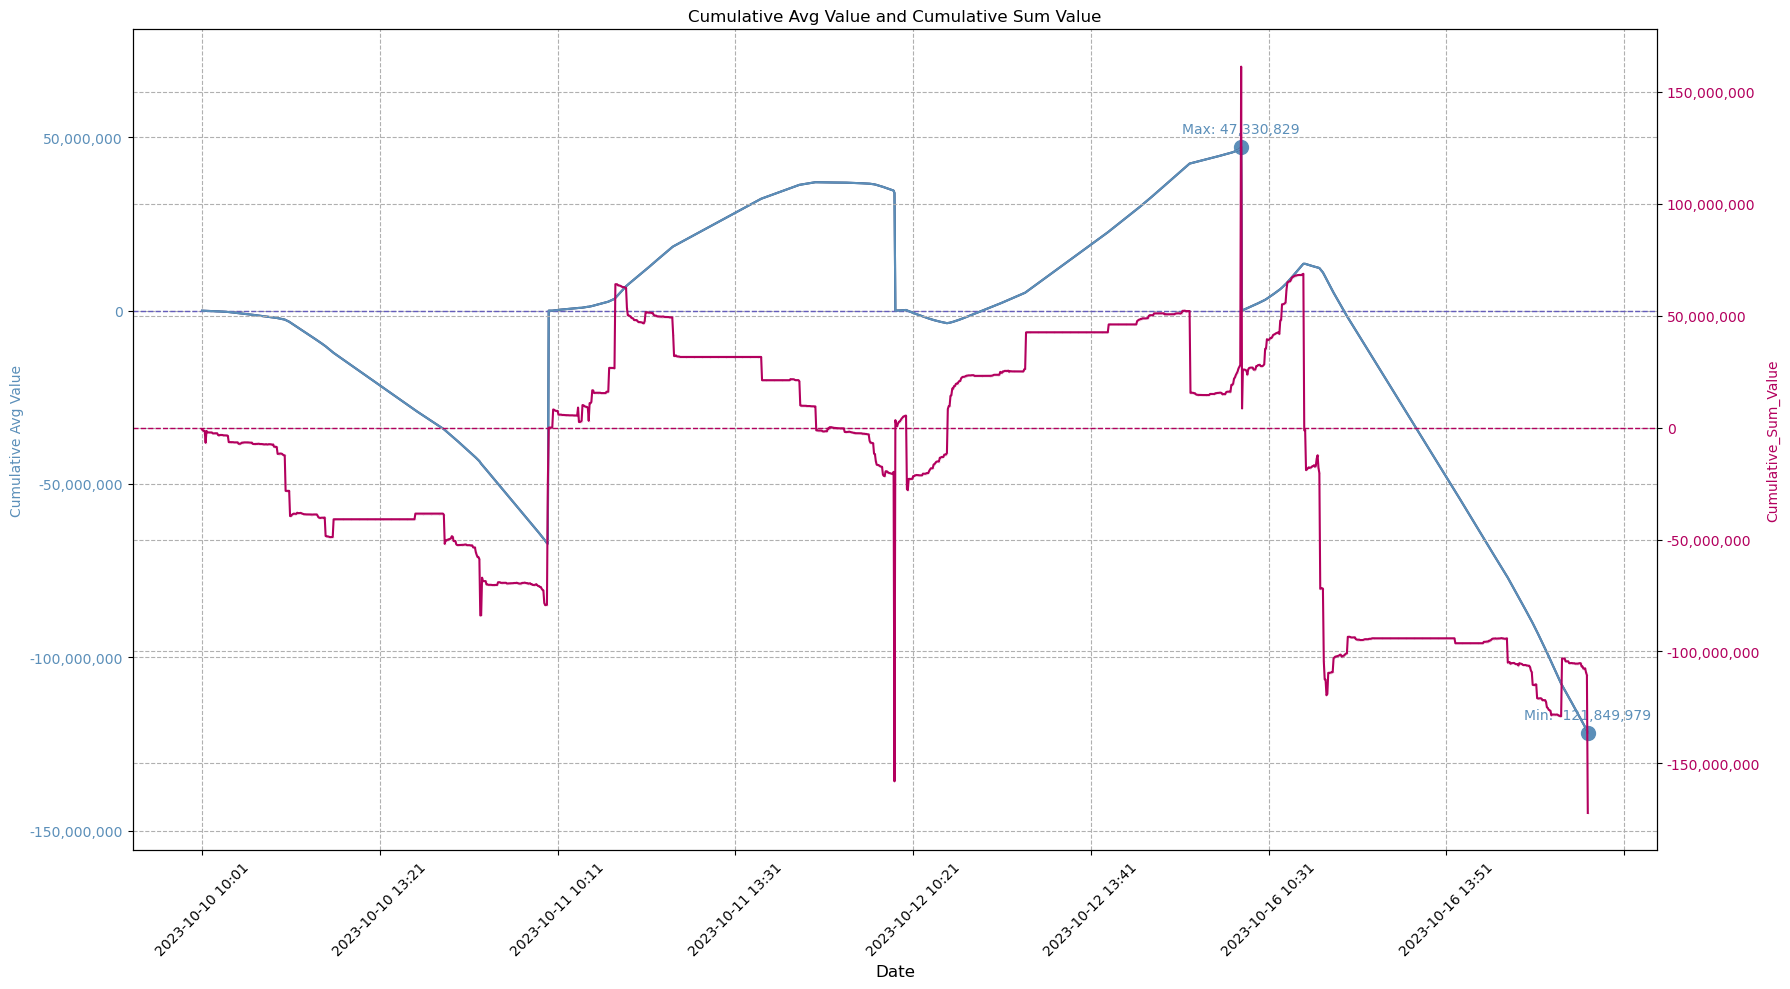

In [38]:
symbols = ['SCC']  #ต้องอยู่ในวงเล็บเท่านั้น!!
day = 4 # ต้องโชว์จำนวนวันในกราฟตามจำนวนวันที่กำหนด = tradeday
finish_date = '2023-10-17' #วันสุดท้าย
min_percentage_change = 0 #หากไม่ต้องการกำหนดรบกวนเขียน None ทั้ง min และ max
max_percentage_change = 3
plotcumulative()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


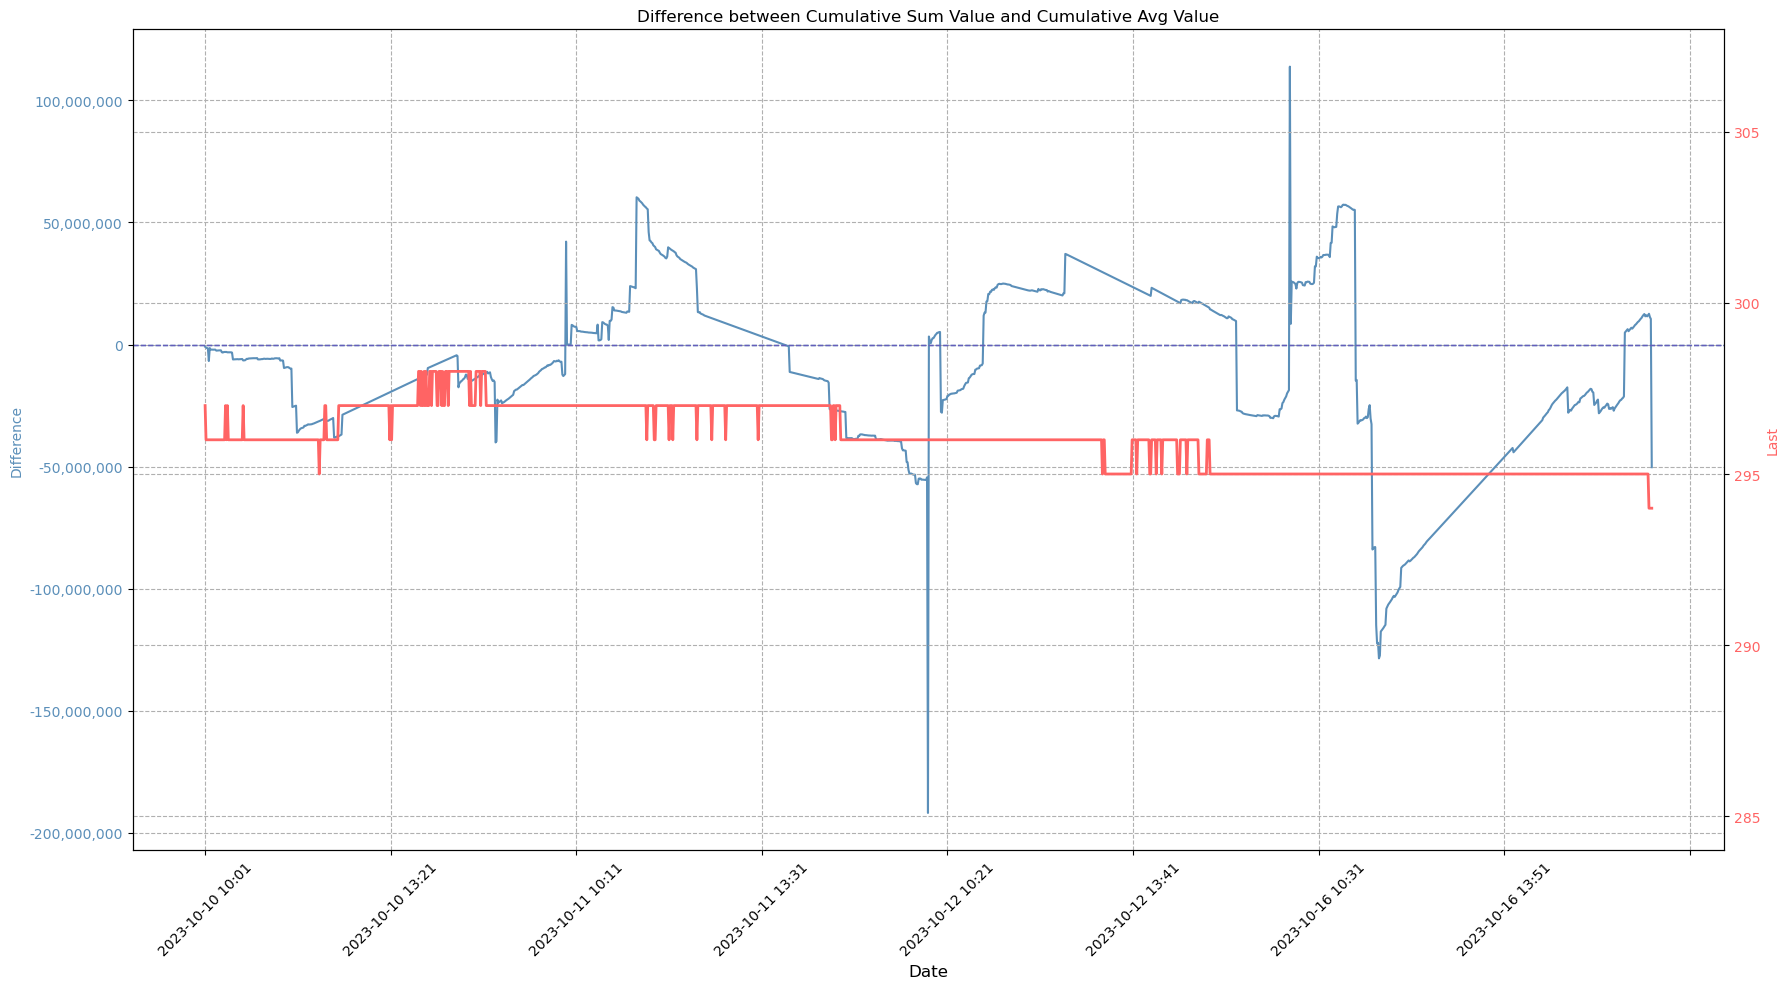

In [39]:
plotDifference()